## Import

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd

from model import (
    load_features,
    train_test_split,
    train_xgboost,
    evaluate_models,
    walk_forward_xgboost
)
from config import RESULTS_DIR


## Load data

In [3]:
df = load_features()
df = df.drop(['sentiment', 'sentiment_lag1', 'sentiment_scaled'], axis=1)
df

,Close,High,Low,Open,Volume,log_return,volatility_20d,abs_return,return_squared,lag_1,lag_5,lag_10,lag_20,rolling_abs_return_mean_20d,target_volatility
date,,,,,,,,,,,,,,,
1993-03-02,24.793129,24.793129,24.413818,24.448301,182400,0.014711,0.132770,0.014711,2.164163e-04,-0.002818,-0.000714,-0.025552,0.007088,0.005358,0.109393
1993-03-03,24.896584,24.913825,24.793135,24.827618,280100,0.004164,0.133244,0.004164,1.733915e-05,0.014711,0.012793,-0.000719,0.002116,0.005460,0.108619
1993-03-04,24.758654,24.931068,24.758654,24.931068,89500,-0.005556,0.129991,0.005556,3.086378e-05,0.004164,0.002116,-0.000720,0.010516,0.005212,0.107369
1993-03-05,24.689671,24.896567,24.672429,24.793119,40000,-0.002790,0.129423,0.002790,7.784712e-06,-0.005556,0.001408,0.003593,0.004175,0.005143,0.131426
1993-03-08,25.241400,25.241400,24.741399,24.741399,50800,0.022101,0.151809,0.022101,4.884336e-04,-0.002790,-0.002818,0.003580,-0.000694,0.006213,0.103419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-16,691.659973,694.250000,690.099976,693.659973,79289200,-0.000838,0.072942,0.000838,7.026390e-07,0.002720,0.006592,0.001831,-0.011065,0.003977,NaN
2026-01-20,677.580017,684.770020,676.570007,681.489990,111623300,-0.020567,0.104281,0.020567,4.229939e-04,-0.000838,0.001569,0.006638,0.007523,0.004629,NaN
2026-01-21,685.400024,688.739990,678.130005,679.650024,127844500,0.011475,0.107342,0.011475,1.316755e-04,-0.020567,-0.002001,0.005930,0.009023,0.004752,NaN


## Test Train Chronological Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df)

Train: (6625, 8), Test: (1657, 8)


## Train model

In [5]:
xgb_model = train_xgboost(X_train, y_train)

## Predict 

In [6]:

y_pred = xgb_model.predict(X_test)

## Evaluate

In [7]:
## Evaluate (Fixed for 2026 NaNs)
# Create a filter to remove NaN values in y_test because they cause issues in evaluation metrics
mask = ~y_test.isna()

metrics = evaluate_models(
    y_test[mask].values, 
    y_pred[mask], 
    model_name="XGBoost"
)


 XGBoost Performance:
 RMSE: 0.1007
 MAE: 0.0563
 R-squared: 0.2314


## XGBoost: Predicted vs True Volatility chart

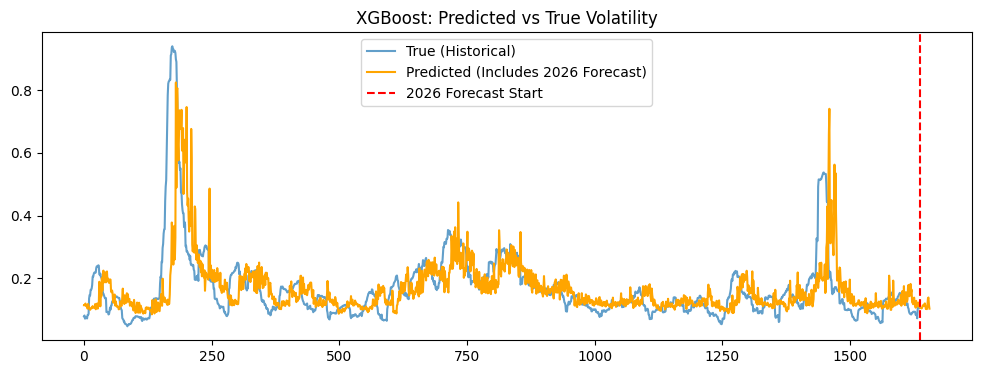

In [8]:
## XGBoost: Predicted vs True Volatility chart
plt.figure(figsize=(12,4))
# Only plot the historical part for 'True'
plt.plot(y_test[mask].values, label="True (Historical)", alpha=0.7)
# Plot the full prediction including the live 2026 forecast
plt.plot(y_pred, label="Predicted (Includes 2026 Forecast)", color='orange')
plt.axvline(x=len(y_test)-20, color='red', linestyle='--', label='2026 Forecast Start')
plt.legend()
plt.title("XGBoost: Predicted vs True Volatility")
plt.savefig(f"{RESULTS_DIR}/figures/xgboost/Predicted_vs_True_Volatility.png", dpi=300, bbox_inches="tight")

## Walk forward validation (retrain every 20 days)

In [10]:
## Walk forward validation (retrain every 20 days)
print("\n" + "="*50)
print("WALK-FORWARD VALIDATION (retrain every 20 days)")
print("="*50)
# Only run walk-forward on the historical portion
y_pred_walkforward = walk_forward_xgboost(
    X_train, 
    X_test[mask], 
    y_train, 
    y_test[mask], 
    retrain_frequency=20
)

# Evaluate against the same historical portion
metrics_walkforward = evaluate_models(
    y_test[mask].values, 
    y_pred_walkforward, 
    model_name="XGBoost_WalkForward"
)


WALK-FORWARD VALIDATION (retrain every 20 days)
Starting walk-forward validation...
Initial train size: 6625, Test size: 1637
Retraining every 20 days
Day 0/1637: Retraining model (train size: 6625)...
Day 20/1637: Retraining model (train size: 6645)...
Day 40/1637: Retraining model (train size: 6665)...
Day 60/1637: Retraining model (train size: 6685)...
Day 80/1637: Retraining model (train size: 6705)...
Day 100/1637: Retraining model (train size: 6725)...
Day 120/1637: Retraining model (train size: 6745)...
Day 140/1637: Retraining model (train size: 6765)...
Day 160/1637: Retraining model (train size: 6785)...
Day 180/1637: Retraining model (train size: 6805)...
Day 200/1637: Retraining model (train size: 6825)...
Day 220/1637: Retraining model (train size: 6845)...
Day 240/1637: Retraining model (train size: 6865)...
Day 260/1637: Retraining model (train size: 6885)...
Day 280/1637: Retraining model (train size: 6905)...
Day 300/1637: Retraining model (train size: 6925)...
Day 32

## Walk-forward v Standard Results

In [11]:
print("\n" + "="*50)
print("COMPARISON")
print("="*50)
comparison = pd.DataFrame([metrics, metrics_walkforward])
print(comparison)


COMPARISON
                 model      rmse       mae  R_squared
0              XGBoost  0.100700  0.056269   0.231422
1  XGBoost_WalkForward  0.099839  0.056690   0.244512


## Save Predictions 

In [ ]:
## Save Predictions (Split into History and Live Forecast)
preds_df = pd.DataFrame({
    "actual_volatility": y_test.values,
    "xgboost_forecast": y_pred_walkforward,
}, index=y_test.index)


# Save the full file (it contains both historical backtest and the 2026 forecast)
preds_df.to_csv(RESULTS_DIR / "preds" / "xgboost_preds.csv", index=True)



✅ All predictions saved to C:\Users\hp\Financial-volatility-forecasting\results\preds\xgboost_preds.csv

🚀 LIVE 2026 FORECASTS (The rows you saw as empty targets):
            xgb_pred
date                
2025-12-24  0.111727
2025-12-26  0.105551
2025-12-29  0.106446
2025-12-30  0.104669
2025-12-31  0.104669
2026-01-02  0.108526
2026-01-05  0.114242
2026-01-06  0.113067
2026-01-07  0.112647
2026-01-08  0.117889
2026-01-09  0.120419
2026-01-12  0.110624
2026-01-13  0.102783
2026-01-14  0.105191
2026-01-15  0.102016
2026-01-16  0.112622
2026-01-20  0.135235
2026-01-21  0.139175
2026-01-22  0.115623
2026-01-23  0.103652


## Feature importance

In [12]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10))



Top 10 Features:
                       feature  importance
7  rolling_abs_return_mean_20d    0.607939
0               volatility_20d    0.191571
3                        lag_1    0.058552
1                   abs_return    0.042802
5                       lag_10    0.034490
4                        lag_5    0.033109
6                       lag_20    0.031538
2               return_squared    0.000000
8                    sentiment    0.000000
9               sentiment_lag1    0.000000


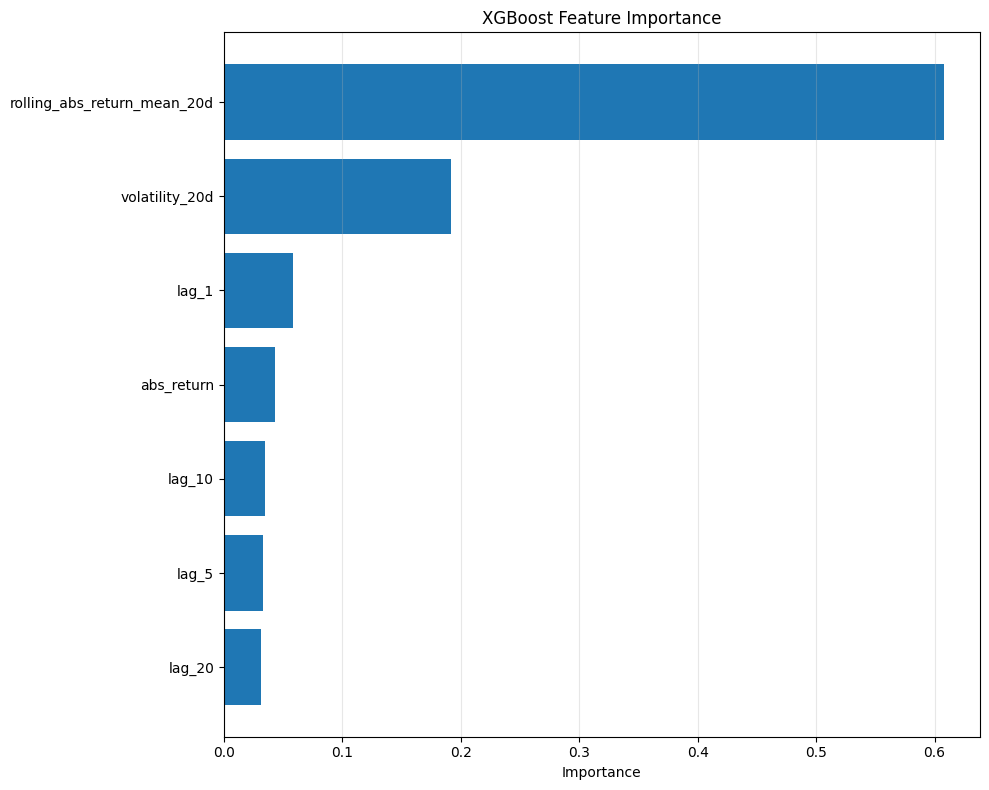

In [17]:
plt.figure(figsize=(10, 8))
top_features = importance_df.head(7)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/figures/xgboost/feature_importance.png", dpi=300, bbox_inches="tight")

## Save Metrics

In [ ]:
metrics_df = pd.DataFrame([metrics_walkforward])
metrics_df.to_csv(RESULTS_DIR / "metrics" / "xgboost_metrics.csv", index=False)
print(f"\n✅ Metrics saved to {RESULTS_DIR / 'metrics' / 'xgboost_metrics.csv'}")



✅ Metrics saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\xgboost_metrics.csv
